#**Machine Remaining Useful Life Estimation Using LSTM**

Predicting the Remining Useful Life for machine using Long-Short Term Memory Network (LSTM)

##Imports:

Imoprt the necessary files and packages.

In [ ]:
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

from PreProcessing import *
from model import *
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import mean_squared_error
import torch.nn as nn
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)



##Load N-CMAPSS Dataset

In [ ]:
#X  will be in the form pandas DataFrame, and the target Y will be a numpy array
(X_dev,y_dev),(X_test,y_test) = load_NCMAPSS_data() 


##Prepare the Data for trainig

In [ ]:
# Normalize the Data 
X_dev_normalized,X_test_normalized = data_normalization(X_dev,X_test)

In [ ]:
# Create a custom datset Class

class NCMAPPS(Dataset):

    def __init__(self,x,y):
        # Initialize data, download, etc.
        #X and y will be in the form numpy arrays
        
        self.x = x[:,:,4:-1] # Take the coloumns that belongs to the sensors readings
        self.x= torch.tensor(self.x).float() # Convert to torch tensor
        self.y= torch.tensor(y)
        self.n_samples = x.shape[0]
        
    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [ ]:
# Generate a sequences from the dataset to be used as samples
def sequence_generator(df_X,Y,sequence_length):
  '''
  parameters:
  df_X: Dataframe object that contains the features values shape (N,P)
  Y : the target output shape (N,1)
  sequence_length : number of measurments(rows) to be considered as one sample


  return:
    X : reshaped version of the df_X values into (N,sequence_length,P) where each X[i] represent a sample
    Y : reshaped version of the Y values into (N/sequence_length,1)
  '''
  N = df_X.shape[0] # Number of measurments
  P = df_X.shape[1] # number of featutres

  # Initialize the output
  X = np.zeros((0,sequence_length,P))
  y = np.zeros((0,1))

  # the units contaained on the df_X
  n_units = np.unique(df_X.unit)
  
  # For each unit reshape the data into 3D and concatenate it for all units
  for u in n_units:

    unit = np.array(df_X[df_X.unit==u].values)
    target = Y[df_X.unit==u]
    x = np.zeros((int(unit.shape[0]/sequence_length),sequence_length,P))
    y_ = np.zeros((int(unit.shape[0]/sequence_length),1))
    for i in range(0,int(unit.shape[0]/sequence_length)):
      x[i] = unit[i*sequence_length:(i+1)*sequence_length]
      y_[i] = target[i*sequence_length]
    
    X = np.concatenate((X,x),axis=0)
    
    y = np.concatenate((y,y_),axis=0)
    
  
  return X,y


In [ ]:
X_dev,y_dev1 = sequence_generator(X_dev_normalized,y_dev,100)
print(X_dev.shape)
print(X_dev_normalized.shape)

(48850, 100, 32)
(4885389, 32)


In [ ]:
train_set = NCMAPPS(X_dev,y_dev1)

In [ ]:
train_loader = DataLoader(train_set,batch_size=1024,shuffle=False)

##Define and train the Model 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class LSTM(nn.Module):
  
    '''
    Long-Short Term memory Network Model
    '''
    def __init__(self, input_size, hidden_size,num_layers):
        '''
        Parameters :
        input_size : the number of features in the input
        hidden_size : the number of the hidden units for the lstm
        num_layers : the number of layers for the LSTM 

        '''
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size = input_size,hidden_size= hidden_size,num_layers = num_layers,batch_first = True).to(device)
        
        self.linear = nn.Linear(hidden_size, 1).to(device)
        
    def forward(self, x):
            
        lstm_out, self.hidden = self.lstm(x)
        
        output = self.linear(lstm_out[:,-1,:])
        
        return output

In [ ]:
# Create object from the LSTM
Model = LSTM(input_size = 27,hidden_size = 27,num_layers = 2)

# Loss function
loss_fn = nn.MSELoss()

# The optimizer
optim = torch.optim.Adam(Model.parameters())

In [ ]:
#Training loop 
def training_loop(n_epochs, optimiser, model, loss_fn, train_loader):
  '''
  Parameters:
  n_epochs :  number of epochs
  optimiser : optimiser used for training
  model : the model to be trained 
  loss_fn : loss function used to train the model
  batch_size : the batch size 
  train_loader : dataloader object to load the training data during the training
  '''
  train_curve = []
  for epoch in range(1, n_epochs + 1):
    loss = [] # the loss for each epoch
    for i ,(features,targets) in enumerate(train_loader):
      
      features= features.to(device)
      targets= targets.to(device)
      output_train = model.forward(features) # forwards pass
      
      targets = torch.tensor(targets,dtype=torch.float32)
      loss_train = loss_fn(output_train, targets) # calculate loss
      optimiser.zero_grad() # set gradients to zero
      loss_train.backward() # backwards pass
      optimiser.step() # update model parameters
      loss.append(loss_train.item())    

    train_curve.append(np.mean(loss))
    print(f"Epoch {epoch}, Training loss {np.mean(loss):.4f},")
    

  return train_curve

In [ ]:
train_curve = training_loop(500,optim,Model,loss_fn,train_loader)

Epoch 1, Training loss 1424.7142,
Epoch 2, Training loss 1231.2961,
Epoch 3, Training loss 1103.3770,
Epoch 4, Training loss 1027.3264,
Epoch 5, Training loss 965.2328,
Epoch 6, Training loss 910.9578,
Epoch 7, Training loss 862.4321,
Epoch 8, Training loss 818.6203,
Epoch 9, Training loss 778.8738,
Epoch 10, Training loss 742.7277,
Epoch 11, Training loss 709.8195,
Epoch 12, Training loss 679.8505,
Epoch 13, Training loss 652.5649,
Epoch 14, Training loss 627.7376,
Epoch 15, Training loss 605.1669,
Epoch 16, Training loss 584.6695,
Epoch 17, Training loss 566.0774,
Epoch 18, Training loss 549.2359,
Epoch 19, Training loss 534.0016,
Epoch 20, Training loss 520.2417,
Epoch 21, Training loss 507.8324,
Epoch 22, Training loss 496.6588,
Epoch 23, Training loss 486.6141,
Epoch 24, Training loss 477.5989,
Epoch 25, Training loss 469.5210,
Epoch 26, Training loss 462.2949,
Epoch 27, Training loss 455.8416,
Epoch 28, Training loss 450.0879,
Epoch 29, Training loss 444.9664,
Epoch 30, Training 

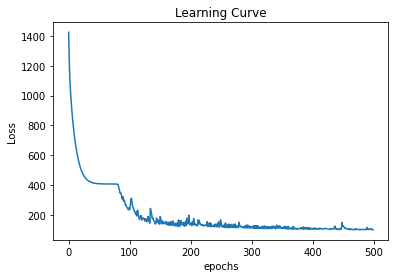

In [ ]:
plt.plot(train_curve)
plt.title('Learning Curve')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.show()

##Model Evaluation:

In [ ]:
def predict(model,data_set):
  '''
  function to predict the rul 
  parameter:
  model : the trained model to predcit the output
  data_set : data_set object to predict the ouput for it
  '''
  batch_size = 1024
  y_pred = np.zeros((len(data_set),1)) # vector to save the predicted output
  
  data_loader = DataLoader(dataset = data_set,batch_size = batch_size,shuffle = False)
  for i,(x,y) in enumerate(data_loader):
    model.train(False)
    x = x.to(device)
    y_p = model.forward(x)
    y_pred[i*batch_size:(i*batch_size+y_p.shape[0])] = y_p.cpu().detach().numpy()
  
  return y_pred

In [ ]:
y_pred = predict(Model,train_set)

In [ ]:
mse_train = mean_squared_error(y_dev1,y_pred)
rmse_train = mean_squared_error(y_dev1,y_pred,squared=False)

print(f'The mean squared error for train set      :  {np.mean(mse_train):.4f}')
print(f'The root mean squared error for train set :  {np.mean(rmse_train):.4f}')

The mean squared error for train set      :  90.4913
The root mean squared error for train set :  9.5127


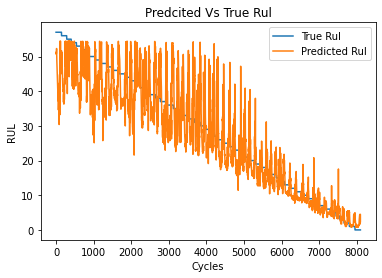

In [ ]:

#Plot the prediction for the specific unit

unit = 6 # For the dev set it range from 1 to 9 
index = X_dev[:,0,0]==unit


plt.plot(y_dev1[index],label='True Rul')
plt.plot(y_pred[index],label='Predicted Rul')
plt.xlabel('Cycles')
plt.ylabel('RUL')
plt.legend()
plt.title('Predcited Vs True Rul')
plt.show()

In [ ]:
#---------------Evalute on Test set -----------------------#
X_test,y_test1 = sequence_generator(X_test_normalized,y_test,100)
test_set = NCMAPPS(X_test,y_test)
y_pred = predict(Model,test_set)

mse_test = mean_squared_error(y_test1,y_pred)
rmse_test = mean_squared_error(y_test1,y_pred,squared=False)

print(f'The mean squared error for test set      :  {np.mean(mse_test):.4f}')
print(f'The root mean squared error for test set :  {np.mean(rmse_test):.4f}')

The mean squared error for test set      :  80.0023
The root mean squared error for test set :  8.9444


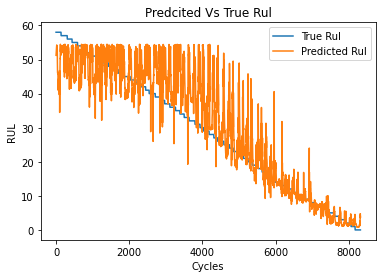

In [ ]:

#Plot the prediction for the specific unit

unit = 14# For the test set it range from 10 to 15 
index = X_test[:,0,0]==unit


plt.plot(y_test1[index],label='True Rul')
plt.plot(y_pred[index],label='Predicted Rul')
plt.xlabel('Cycles')
plt.ylabel('RUL')
plt.legend()
plt.title('Predcited Vs True Rul')
plt.show()